# Batch Effect Calibration Analysis

In this notebook, we will show that CarDEC largely corrects for batch effects when denoising gene expression data. We also examine the denoised/batch corrected counts for other methods including Scanorama, DCA, scVI, and MNN.

Before running this notebook, please run the following scripts/notebooks:

1. "../Evaluations of Competing Methods/MNN_Retina.R"
2. "../Evaluations of Competing Methods/Competing Methods Mouse Retina.ipynb"
3. "CarDEC Mouse Retina.ipynb"

## Analysis Preparation

First, let's import key packages, prepare useful functions, and read the data in.

In [1]:
"""Broadly useful python packages"""
import pandas as pd
import os
import numpy as np
from copy import deepcopy
from math import log
import pickle
from math import floor, log
from PIL import Image

"""Machine learning and single cell packages"""
import matplotlib.pyplot as pyplot
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score as ari, normalized_mutual_info_score as nmi
import torch

"""CarDEC Package"""
from CarDEC import CarDEC_API

"""import scVI Package"""
import scvi
from scvi.model import SCVI

%matplotlib inline

In [2]:
"""Miscellaneous useful functions"""

def read_retina_data(path,cache=True):
    adata = sc.read(os.path.join(path, 'matrix.mtx'), cache=cache).T
    genes_file=pd.read_csv(os.path.join(path, 'genes.tsv'), sep='\t')
    barcodes_file=pd.read_csv(os.path.join(path, 'barcodes.tsv'), sep='\t')
    adata.var_names=genes_file["genename"]
    adata.obs_names=barcodes_file["cellname"]
    adata.var['genenames']=genes_file["genename"].values
    adata.obs['celltype']=barcodes_file["celltype"].values
    adata.obs['celltype_com']=barcodes_file["celltype_com"].values
    adata.obs['celltypeID']=barcodes_file["celltypeID"].values
    adata.obs['BatchID']=barcodes_file["BatchID"].values
    
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=30)
    
    mito_genes = adata.var_names.str.startswith('mt-')
    adata.obs['percent_mito'] = np.sum(
        adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    adata = adata[adata.obs['n_genes'] < 2500, :]
    adata = adata[adata.obs['percent_mito'] < 0.05, :]
    return(adata)

def convert_string_to_encoding(string, vector_key):
    """A function to convert a string to a numeric encoding"""
    return np.argwhere(vector_key == string)[0][0]

def convert_vector_to_encoding(vector, printkey = False):
    """A function to convert a vector of strings to a dense numeric encoding"""
    vector_key = np.unique(vector)
    if printkey:
        print(pd.Series(vector_key))
    
    vector_strings = list(vector)
    vector_num = [convert_string_to_encoding(string, vector_key) for string in vector_strings]
    
    return vector_num

def purity_score(y_true, y_pred):
    """A function to compute cluster purity"""
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)

    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def package_adata(matrix, inherit, index = None, normalize = True):
    packaged = AnnData(matrix)
    packaged.var.index = inherit.var.index
    packaged.obs["cell_type"] = list(inherit.obs['celltype'])
    packaged.obs["BatchID"] = list(inherit.obs['BatchID'])
    
    if normalize:
        sc.pp.normalize_total(packaged)
        sc.pp.log1p(packaged)
    
    if index is not None:
        packaged.obs.index = index
    
    return packaged

def create_subdataset(adata, type_):   
    sample = deepcopy(adata.X)
    celltype = adata.obs['cell_type'].values
    trimmed_batch = deepcopy(adata.obs["BatchID"])
    id_vector = [x == celltype_key[type_] for x in celltype]
    sample = sample[id_vector,]
    trimmed_batch = trimmed_batch[id_vector]
    return [sample, trimmed_batch, adata.var.index]

def find_resolution(adata_, n_clusters, random = 0): 
    adata = adata_.copy()
    obtained_clusters = -1
    iteration = 0
    resolutions = [0., 1000.]
    
    while obtained_clusters != n_clusters and iteration < 50:
        current_res = sum(resolutions)/2
        sc.tl.louvain(adata, resolution = current_res, random_state = random)
        labels = adata.obs['louvain']
        
        obtained_clusters = len(np.unique(labels))
        
        if obtained_clusters < n_clusters:
            resolutions[0] = current_res
        else:
            resolutions[1] = current_res
        
        iteration = iteration + 1
        
    return current_res

def build_dir(dir_path):
    subdirs = [dir_path]
    substring = dir_path

    while substring != '':
        splt_dir = os.path.split(substring)
        substring = splt_dir[0]
        subdirs.append(substring)
        
    subdirs.pop()
    subdirs = [x for x in subdirs if os.path.basename(x) != '..']

    n = len(subdirs)
    subdirs = [subdirs[n - 1 - x] for x in range(n)]
    
    for dir_ in subdirs:
        if not os.path.isdir(dir_):
            os.mkdir(dir_)

metrics_ = [ari, nmi, purity_score]

The number of cells of type: BC1A is 943
The number of cells of type: BC1B is 707
The number of cells of type: BC2 is 462
The number of cells of type: BC3A is 438
The number of cells of type: BC3B is 702
The number of cells of type: BC4 is 321
The number of cells of type: BC5A is 2006
The number of cells of type: BC5B is 388
The number of cells of type: BC5C is 1194
The number of cells of type: BC5D is 465
The number of cells of type: BC6 is 1498
The number of cells of type: BC7 is 1471
The number of cells of type: BC8/9 is 263
The number of cells of type: RBC is 9409


/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


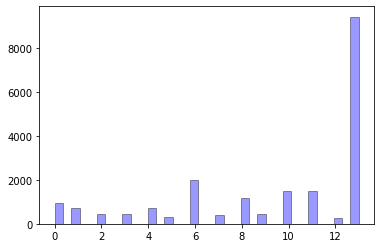

In [3]:
adata = read_retina_data("../Data/retina_to_mingyao", cache=True)

celltype = adata.obs['celltype'].values
celltype_vec = convert_vector_to_encoding(celltype)

sns.distplot(celltype_vec, hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

celltype_key = np.unique(adata.obs['celltype'].values)
for type_ in celltype_key:
    ntype = sum([x == type_ for x in celltype])
    print("The number of cells of type: " + type_ + " is " + str(ntype))

## Get the denoised counts

Next, let's load the weights for the CarDEC model and get the denoised output.

In [4]:
CarDEC = CarDEC_API(adata, weights_dir = "Retina All/CarDEC_LVG Weights", batch_key = "BatchID", n_high_var = 2000)

CarDEC.build_model(n_clusters = 12)

CarDEC.make_inference()

CarDEC.model_counts()

Trying to set attribute `.var` of view, copying.
... storing 'celltype' as categorical
... storing 'celltype_com' as categorical
... storing 'BatchID' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                260256    
_________________________________________________________________
decoder (Sequential)         (None, 2000)              262224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   1371680   
_________________________________________________________________
decoderLVG (Sequential)      (1, 10683)                1386427   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  384       
Total params: 3,280,971
Trainable params: 3,280,971
Non-trainable para

Let's also load the denoised counts for DCA and scVI, and the batch corrected counts from MNN.

In [5]:
"""DCA Denoised Counts"""
dca_denoised = sc.read("../Evaluations of Competing Methods/DCA Results/NB Retina/DCA_denoise.h5ad")

"""scVI Denoised Counts"""
anndataset = adata.copy()
scvi.data.setup_anndata(anndataset, batch_key = "BatchID")

vae = SCVI(anndataset, n_layers = 2)

filename = '../Evaluations of Competing Methods/scVI Results All/Retina/bestmodelnew'

if not os.path.exists(filename):
    vae.train(n_epochs = 200)
    vae.save(dir_path = filename)
        
vae = vae.load(anndataset, dir_path = filename)

latent = vae.get_latent_representation()
normalized_values = vae.get_normalized_expression(
    library_size=1e4, 
    transform_batch = "Bipolar1", 
    n_samples=10, 
    return_mean=True,
)

scvi_denoised = AnnData(deepcopy(normalized_values))
scvi_denoised.obs = anndataset.obs

"""MNN Batch Corrected Counts"""

MNNdata = pd.read_csv("../Evaluations of Competing Methods/MNNcorrected/corrected_data_Retina.csv", index_col = 0)
meta_data = pd.read_csv("../Evaluations of Competing Methods/MNNcorrected/corrected_metadata_Retina.csv", index_col = 0)
MNNdata = MNNdata.T

MNN_denoised = AnnData(MNNdata)
MNN_denoised.obs = meta_data
adata = read_retina_data("../Data/retina_to_mingyao", cache=True)

print("Verifying that cell type labels in output object are same as labels in MNN_denoised: computing ARI:")
print(ari(CarDEC.dataset.obs['celltype'], MNN_denoised.obs['celltype']))

MNN_denoised.obs['celltype'] = CarDEC.dataset.obs['celltype'].values

del MNNdata, meta_data, adata
anndataset.obs['BatchID'] = CarDEC.dataset.obs['BatchID']
MNN_denoised

INFO     Using batches from adata.obs["BatchID"]                                             
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 20267 cells, 12683 genes, 6       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([2, 3], dtype='int64'), …


Verifying that cell type labels in output object are same as labels in MNN_denoised: computing ARI:
1.0


AnnData object with n_obs × n_vars = 20267 × 12683
    obs: 'cellname', 'celltype', 'celltype_com', 'celltypeID', 'BatchID'

Lastly, let's normalize the counts for downstream analysis.

In [6]:
denoised =  deepcopy(CarDEC.dataset.layers["denoised counts"])
raw_counts = deepcopy(CarDEC.dataset.X)

adata_d = package_adata(denoised, index = CarDEC.dataset.obs.index, inherit = CarDEC.dataset)
adata_r = package_adata(raw_counts, index = CarDEC.dataset.obs.index, inherit = CarDEC.dataset)
adata_dca = package_adata(deepcopy(dca_denoised), index = dca_denoised.obs.index, inherit = dca_denoised)
adata_scvi = package_adata(deepcopy(scvi_denoised), index = anndataset.obs.index, inherit = anndataset)

tmp = sc.pp.combat(adata_dca, key = 'BatchID', inplace = False)
adata_dca.X = tmp

adata_mnn = MNN_denoised
adata_mnn.obs['cell_type'] = adata_mnn.obs['celltype']
adata_mnn.obs.index = adata_mnn.obs['cellname']

def sort_genes(adata):
    tmpindices_d = [x.replace("-", "") for x in adata_d.var.index]
    tmpindices_d = [x.replace("_", "") for x in tmpindices_d]
    tmpindices_nd = [x.replace("-", "") for x in adata.var.index]
    tmpindices_nd = [x.replace("_", "") for x in tmpindices_nd]
    assert len(np.unique(tmpindices_d)) == len(tmpindices_d)
    assert len(np.unique(tmpindices_nd)) == len(tmpindices_nd)
    indices = [np.where(np.asarray(tmpindices_nd) == x)[0][0] for x in tmpindices_d]
    adata = adata[:, indices]
    adata.var.index = adata_d.var.index
    return adata

adata_dca.X[adata_dca.X < 0.] = 0.
adata_mnn.X[adata_mnn.X < 0.] = 0.

datasets = [adata_d, adata_r, adata_dca, adata_scvi, adata_mnn]
datasets = [sort_genes(ds) for ds in datasets]
names = ['CarDEC', "Raw", "DCA", "scVI", "MNN"]

... storing 'BatchID' as categorical
... storing 'cell_type' as categorical


## Empirical CDF Analysis

In this section, our goal is to pick out some genes and examine their empirical cumulative distribution functions. We will pick out two cell types. Within each cell type we will plot one empirical CDF for each batch, and we will do this for both the raw counts and the denoised counts of each method.

First let's pick out some highly expressed genes, and some moderately expressed genes.

In [9]:
ranks = np.argsort(np.mean(adata_r.X, axis = 0)) #Get gene indices in order of increasing expression
n = ranks.shape[0]
ranks = [ranks[n - 1 - x] for x in list(range(n))] #Reverse order to rank cells in order of decreasing expression

#Compare raw ECDF to full ECDF

index_list = [0, 1, 2, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 3000, 3500, 4500, 5000, 6000, 7000, 8000, 9000, 10000] 
index_list = [ranks[x] for x in index_list]

gene_names = adata_r.var.index[index_list]

## Cell Type 3 (BC3A) Analysis

First, let's look at ECDFs of expression by batch within cell type 3: BC3A. Note that this is one of the rarer cell types in our dataset.

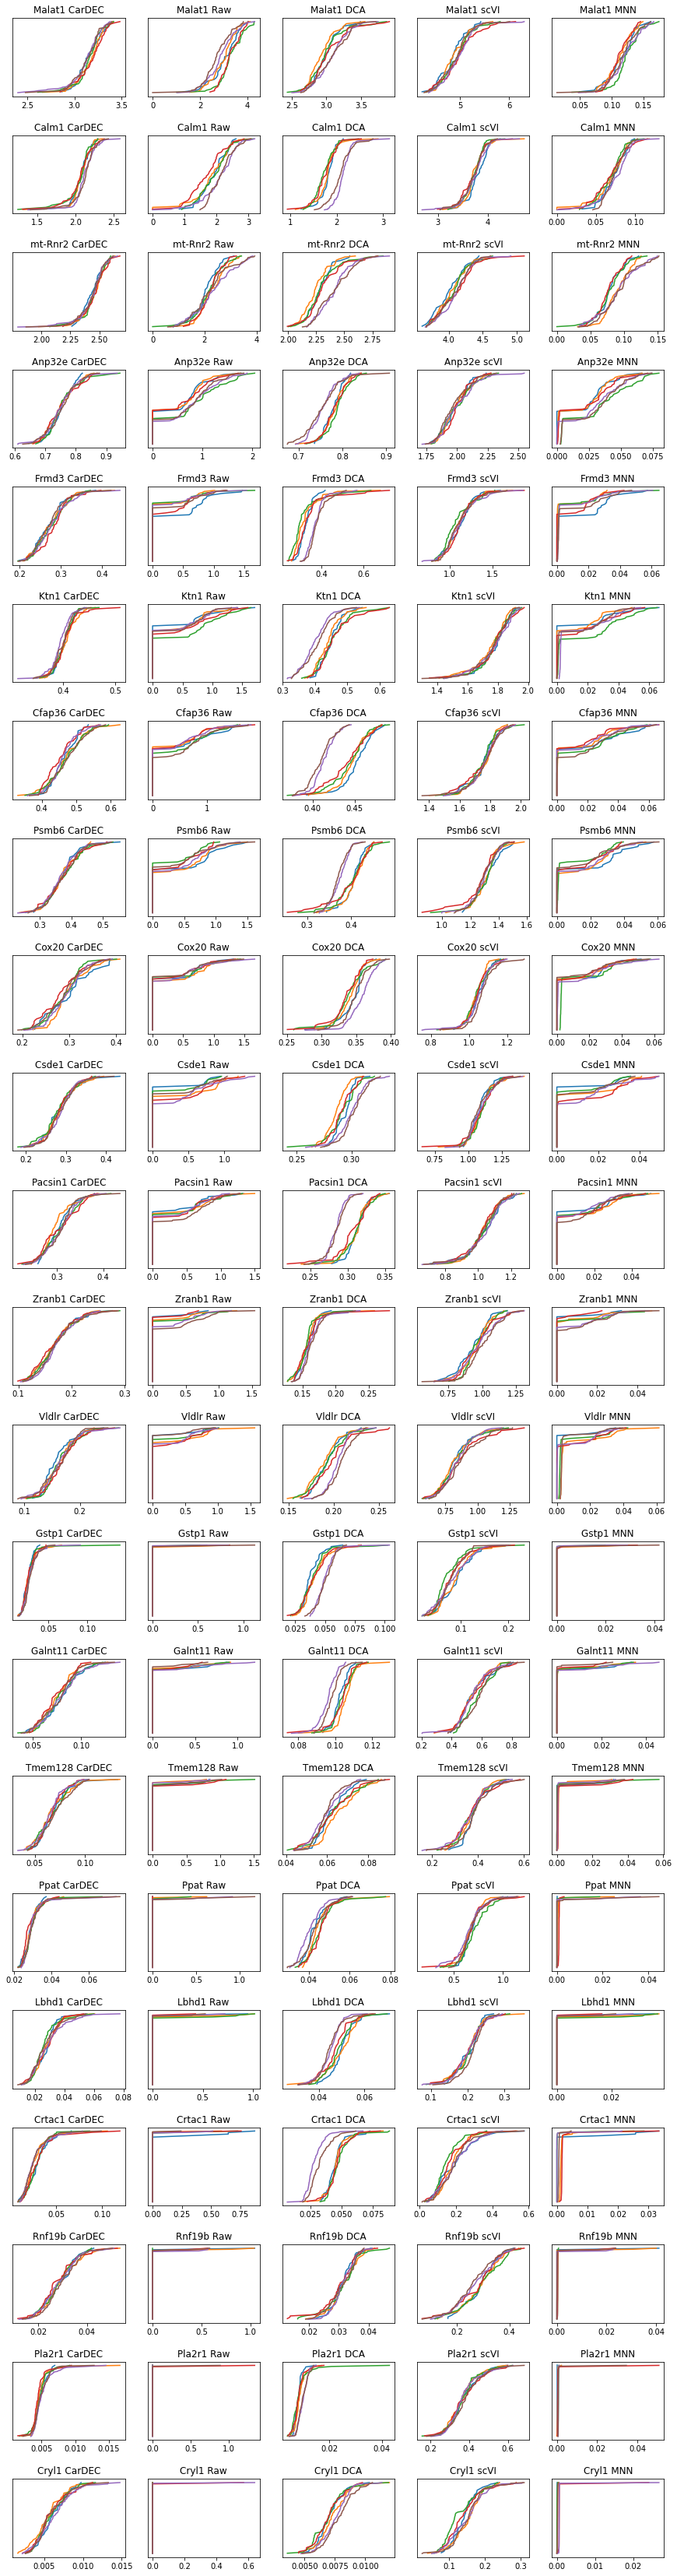

In [10]:
batch_key = np.unique(adata_r.obs['BatchID'])

subdatasets = [create_subdataset(ds, type_ = 3) for ds in datasets]

fig, axes = pyplot.subplots(len(index_list), 5, figsize = (15, 60))

index_count = 0
for gene in gene_names:

    method_count = 0
    for subdataset in subdatasets:
        sample, trimmed_batch, genes = subdataset
        index = np.argwhere([x in [gene] for x in list(genes)])[0][0]
        trimmed_counts = sample[:,index]
        
        for i in range(len(batch_key)):
            trimmed_counts_B = deepcopy(trimmed_counts)
            id_vector = [x == batch_key[i] for x in trimmed_batch]
            trimmed_counts_B = trimmed_counts_B[id_vector,]
            ecdf = ECDF(trimmed_counts_B)
            axes[index_count, method_count].plot(ecdf.x, ecdf.y)
            axes[index_count, method_count].set_yticks([])
            axes[index_count, method_count].title.set_text(gene + " " + names[method_count])
        
        method_count = method_count + 1
    
    index_count = index_count + 1
    
fig.subplots_adjust(hspace=.5)

## Cell Type 13 (RBC) Analysis

First, let's look at ECDFs of expression by batch within cell type 13: RBC.

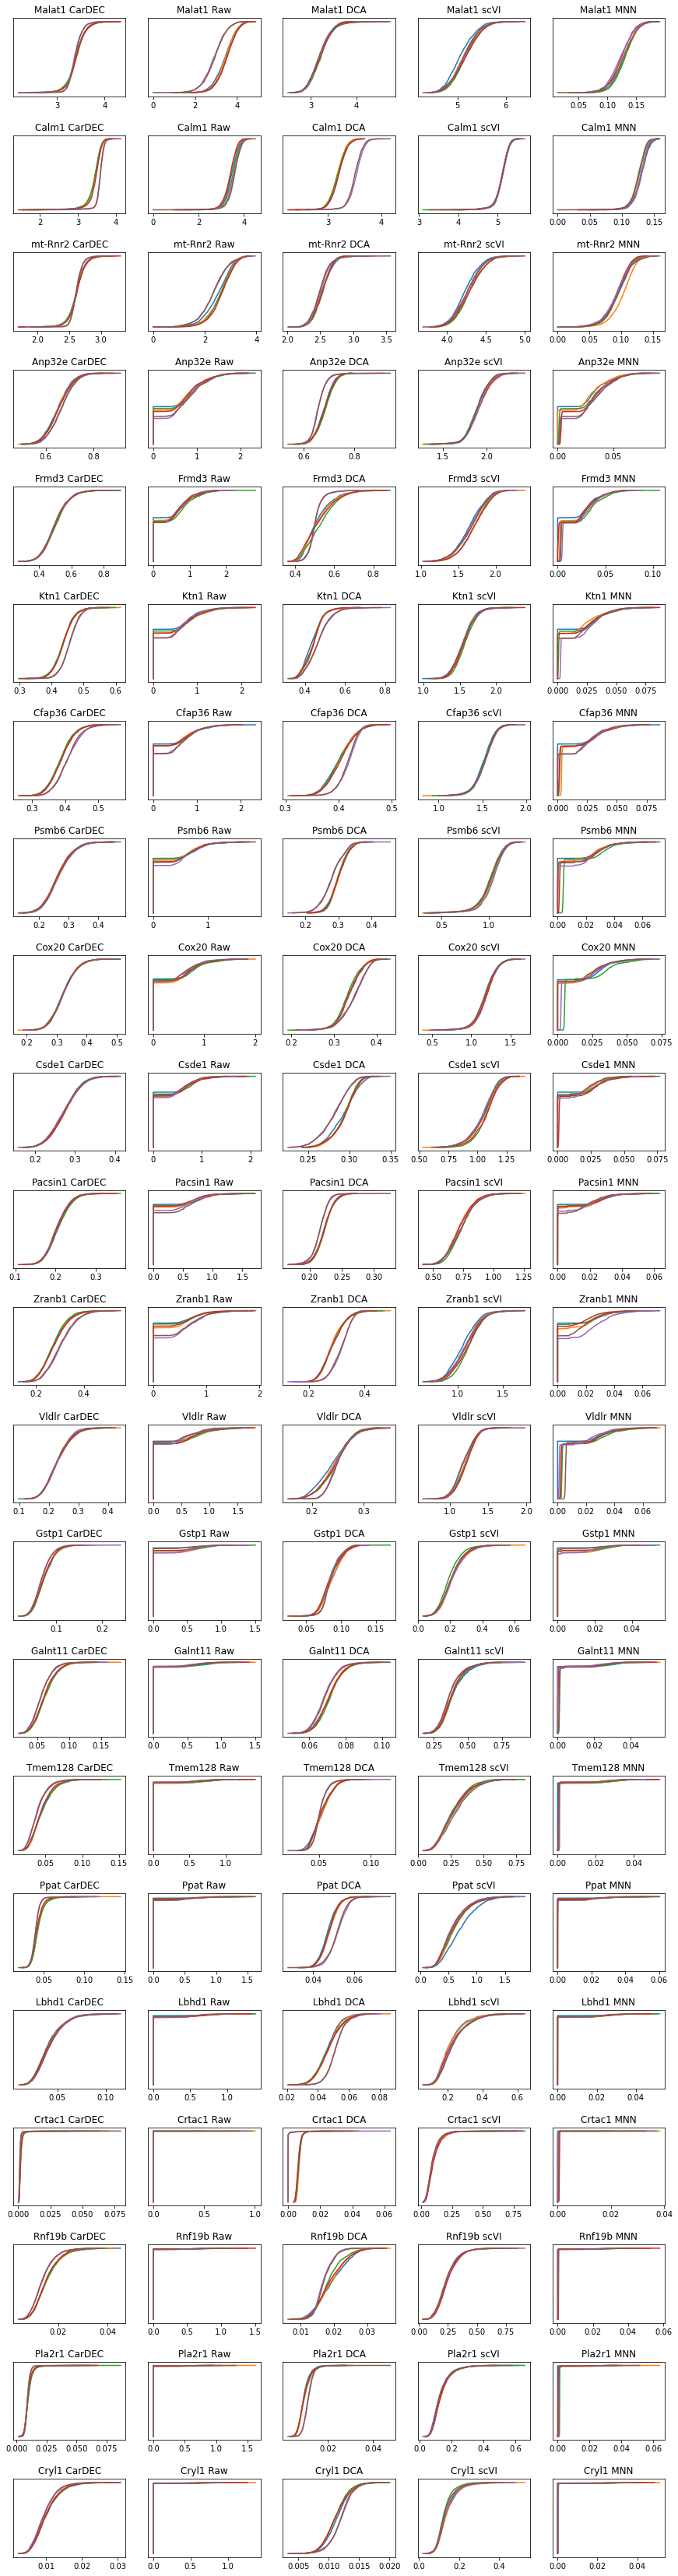

In [11]:
batch_key = np.unique(adata_r.obs['BatchID'])

subdatasets = [create_subdataset(ds, type_ = 13) for ds in datasets]

fig, axes = pyplot.subplots(len(index_list), 5, figsize = (15, 60))

index_count = 0
for gene in gene_names:

    method_count = 0
    for subdataset in subdatasets:
        sample, trimmed_batch, genes = subdataset
        index = np.argwhere([x in [gene] for x in list(genes)])[0][0]
        trimmed_counts = sample[:,index]

        for i in range(len(batch_key)):
            trimmed_counts_B = deepcopy(trimmed_counts)
            id_vector = [x == batch_key[i] for x in trimmed_batch]
            trimmed_counts_B = trimmed_counts_B[id_vector,]
            ecdf = ECDF(trimmed_counts_B)
            axes[index_count, method_count].plot(ecdf.x, ecdf.y)
            axes[index_count, method_count].set_yticks([])
            axes[index_count, method_count].title.set_text(gene + " " + names[method_count])
        
        method_count = method_count + 1
    
    index_count = index_count + 1
    
fig.subplots_adjust(hspace=.5)

## Coefficient of Variation Analysis

While fold change suffices for evaluating batch effect removal in the presence of only two batches, it is not enough to analyze batch effect removal when there are many batches, as fold change is a pairwise metric.

Let $c_{ajb} = \sum_{i \in S_{ab}} x_{ij} / \sum_{i \in S_{ab}} 1$ be the centroid of batch b in cell type a for gene j. Let $C_{aj} = \{c_{ajb}\}$ be the set of all batchwise centroids for cell type a, gene j. Then our metric is $$CV_{aj} = \frac{\sqrt{Var(C_{aj})}}{Mean(C_{aj}) + \gamma} $$

Here $\gamma$ is a very small constant included to mitigate computational instability. Note that coefficient of variation is computed genewise. To compare coefficients of variation between batches for all genes, we can plot a histogram of all of the genewise coefficients of variation before denoising and another histogram after. If our method corrects for batch effects, then we anticipate the coefficients of variation histogram to concentrate more around 0 after denoising.

Note that we may wish to compute a single $CV$ metric across all batches simultaneously. To do this, simply take a weighted average of $C_{aj}$ over index $a$. That is, compute the overall $CV$ as follows:

$$CV_{j} = \sum_a c(a)CV_{aj}$$

where $c(a)$ is defined as follows, and $n$ is the number of cells

$$c(a) = \sum_i I(a_i = a)/n$$

First, let's define the function we will use to compute coefficient of variation.

In [12]:
def centroid_dist(x, y):
    features = pd.DataFrame(x, index = range(x.shape[0]))
    Group = pd.Series(convert_vector_to_encoding(y), index = range(y.shape[0]), name="Group")
    Mergefeature = pd.concat([features, Group],axis=1)
    
    centroids = Mergefeature.groupby("Group").mean()
    result = (centroids.std(axis = 0).to_numpy())/abs(centroids.mean(axis = 0).to_numpy() + 10**(-12))
    
    return result

def centroid_dist_all(x, y, z):
    features = pd.DataFrame(x, index = range(x.shape[0]))
    Group = pd.Series(convert_vector_to_encoding(y), index = range(y.shape[0]), name="Group")
    Type = pd.Series(convert_vector_to_encoding(z), index = range(z.shape[0]), name="Type")
    Mergefeature = pd.concat([features, Group, Type],axis=1)
    n_cells = Type.value_counts().sort_index().to_numpy()

    df = Mergefeature.groupby(["Group", "Type"]).mean()
    df = df.groupby("Type").std()/(df.groupby("Type").mean() + 10**(-12)) * (n_cells/sum(n_cells))[:, None]
    return df[np.invert(np.isnan(df.to_numpy().sum(axis = 1)))].mean(axis = 0)

## Overall CV Analysis

done


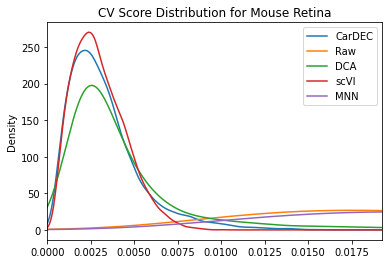

In [13]:
n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for dataset in datasets:    
    FPlist = centroid_dist_all(dataset.X, dataset.obs['BatchID'], dataset.obs['cell_type'])
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['CarDEC'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for Mouse Retina")
print("done")

"""Figure info for paper"""
figure_path = "../Figures/mouse_retina"
build_dir(figure_path)
path = os.path.join(figure_path, 'CVs')

myplot = myplot.get_figure()
myplot.savefig(path + '.png', dpi=300)
im = Image.open(path + '.png')
im.save(path + '.tiff')

In [14]:
hvg_bool = CarDEC.dataset.var['Variance Type'] == 'HVG'
lvg_bool = CarDEC.dataset.var['Variance Type'] == 'LVG'

Let's show the distribution of overall CVs for HVGs Only

done


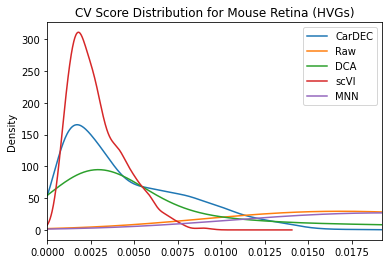

In [15]:
n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for dataset in datasets:  
    dataset = dataset[:, hvg_bool]
    FPlist = centroid_dist_all(dataset.X, dataset.obs['BatchID'], dataset.obs['cell_type'])
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['CarDEC'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for Mouse Retina (HVGs)")
print("done")

"""Figure info for paper"""
figure_path = "../Figures/mouse_retina_supplement"
build_dir(figure_path)
path = os.path.join(figure_path, 'CVs_HVG')

myplot = myplot.get_figure()
myplot.savefig(path + '.png', dpi=300)
im = Image.open(path + '.png')
im.save(path + '.tiff')

Let's show the distribution of overall CVs for LVGs Only

done


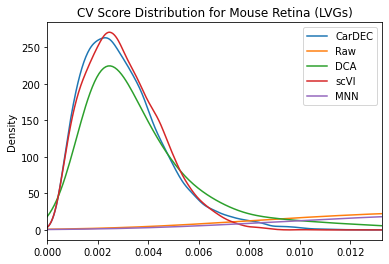

In [16]:
n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for dataset in datasets:  
    dataset = dataset[:, lvg_bool]
    FPlist = centroid_dist_all(dataset.X, dataset.obs['BatchID'], dataset.obs['cell_type'])
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['CarDEC'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for Mouse Retina (LVGs)")
print("done")

"""Figure info for paper"""
figure_path = "../Figures/mouse_retina_supplement"
build_dir(figure_path)
path = os.path.join(figure_path, 'CVs_LVG')

myplot = myplot.get_figure()
myplot.savefig(path + '.png', dpi=300)
im = Image.open(path + '.png')
im.save(path + '.tiff')

In the remainder of this notebook, we look at CV distributions for individual cell types

## Cell Type 0 (BC1A) CV Distribution Analysis

done


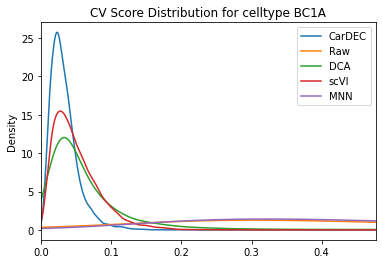

In [17]:
subdatasets = [create_subdataset(ds, type_ = 0) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['CarDEC'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[0])
print("done")

## Cell Type 1 (BC1B) CV Distribution Analysis

done


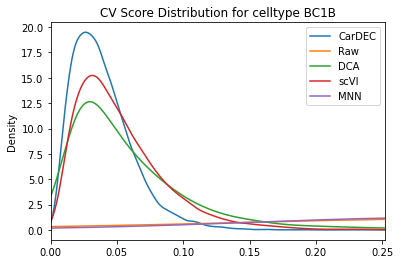

In [18]:
subdatasets = [create_subdataset(ds, type_ = 1) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['CarDEC'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[1])
print("done")

## Cell Type 2 (BC2) CV Distribution Analysis

done


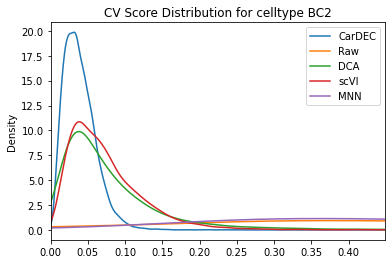

In [19]:
subdatasets = [create_subdataset(ds, type_ = 2) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['CarDEC'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[2])
print("done")

## Cell Type 3 (BC3A) CV Distribution Analysis

done


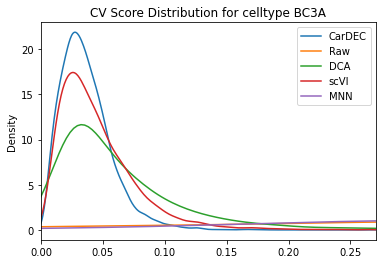

In [20]:
subdatasets = [create_subdataset(ds, type_ = 3) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['CarDEC'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[3])
print("done")

## Cell Type 4 (BC3B) CV Distribution Analysis

done


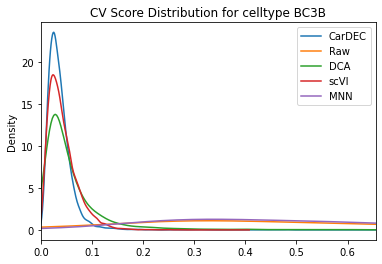

In [21]:
subdatasets = [create_subdataset(ds, type_ = 4) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['CarDEC'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[4])
print("done")

## Cell Type 5 (BC4) CV Distribution Analysis

done


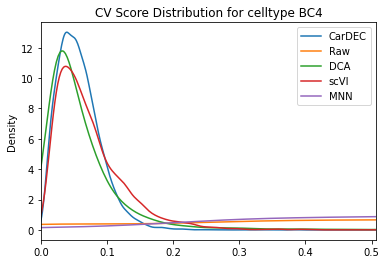

In [22]:
subdatasets = [create_subdataset(ds, type_ = 5) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['CarDEC'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[5])
print("done")

## Cell Type 6 (BC5A) CV Distribution Analysis

done


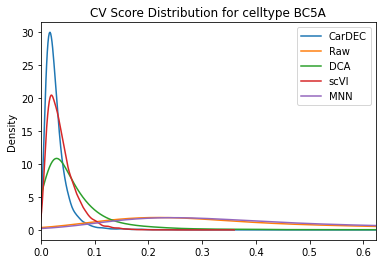

In [23]:
subdatasets = [create_subdataset(ds, type_ = 6) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['CarDEC'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[6])
print("done")

## Cell Type 7 (BC5B) CV Distribution Analysis

done


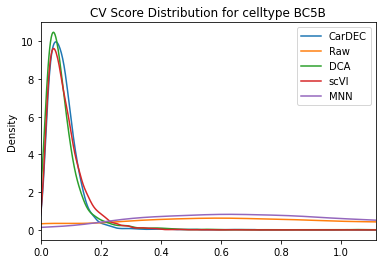

In [24]:
subdatasets = [create_subdataset(ds, type_ = 7) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['CarDEC'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[7])
print("done")

## Cell Type 8 (BC5C) CV Distribution Analysis

done


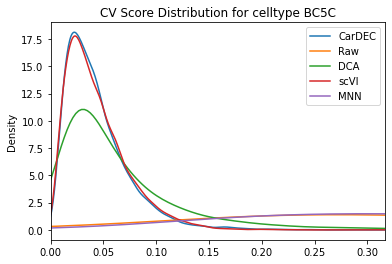

In [25]:
subdatasets = [create_subdataset(ds, type_ = 8) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['CarDEC'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[8])
print("done")

## Cell Type 9 (BC5D) CV Distribution Analysis

done


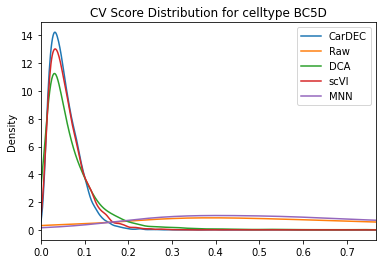

In [26]:
subdatasets = [create_subdataset(ds, type_ = 9) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['CarDEC'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[9])
print("done")

## Cell Type 10 (BC6) CV Distribution Analysis

done


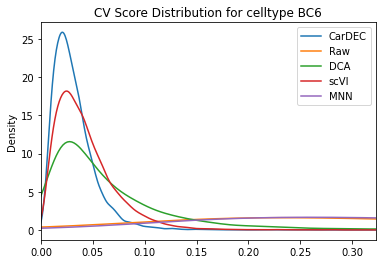

In [27]:
subdatasets = [create_subdataset(ds, type_ = 10) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['CarDEC'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[10])
print("done")

## Cell Type 11 (BC7) CV Distribution Analysis

done


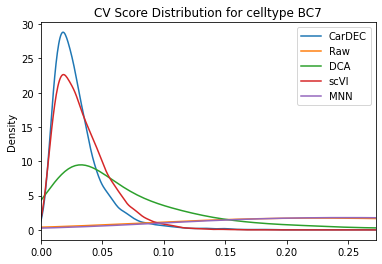

In [28]:
subdatasets = [create_subdataset(ds, type_ = 11) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['CarDEC'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[11])
print("done")

## Cell Type 12 (BC8/9) CV Distribution Analysis

done


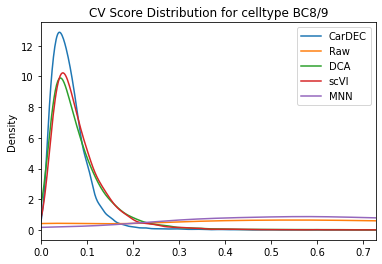

In [29]:
subdatasets = [create_subdataset(ds, type_ = 12) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['CarDEC'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[12])
print("done")

## Cell Type 13 (RBC) CV Distribution Analysis

done


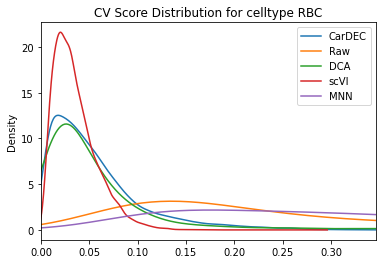

In [30]:
subdatasets = [create_subdataset(ds, type_ = 13) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['CarDEC'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[13])
print("done")